## SESONAL DECOMPOSITION OF COMPOSITIONAL DATA

    Transform microbiome time series using CLR. 
    Perform seasonal decomposition using STL.
    Find the best period for seasonal decomposition by fitting STL seasonal decomposition and analyse whether residual component has unit root. Choose period with the lowest p-value.
    Decompose each time serie using STL.
    Plot seasonal component.
    Plot trend component. 
    
 *** we assume additive time series model as our data is log transformed (STL can be only used to additive time series but we can use STL on log transformed data. As our data is log transformed by CLR we can use STL)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import numpy as np
import seaborn as sns

import os
import sys

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
CLR_DF = pd.read_csv('/Users/zkarwowska/Downloads/male_phylum_clr.csv', index_col = [0]).iloc[11:]

In [3]:
metadata = pd.read_csv('/Users/zkarwowska/Downloads/550_20200106-124938.txt', sep = '\t')
metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                    (metadata['sex'] == 'male') & \
                    (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

In [4]:
series = pd.date_range(start='2008-10-21', end='2010-01-06', freq='D')
CLR_DF.index = series[11:]

In [191]:
def find_best_lag(df):

    FEATURE = []
    PERIOD = []
    PVALUE = []

    df = df[df.index.year == 2009]
    for col in df.columns:

        periods = [i for i in range(2, 30)]
        pval = []
        p = []

        for period in periods:
            results = STL(df[col], period=period).fit()
            residuals = results.resid.dropna()
            pvalue = adfuller(residuals)[1]

            pval.append(pvalue)
            p.append(period)

        adf_pval_df = pd.DataFrame(list(zip(p, pval)), columns = ['lag', 'pvalue'])
        best_lag = adf_pval_df.sort_values(by = ['pvalue']).iloc[0]['lag'].tolist()
        best_pvalue = adf_pval_df.sort_values(by = ['pvalue']).iloc[0]['pvalue'].tolist()

        FEATURE.append(col)
        PERIOD.append(best_lag)
        PVALUE.append(best_pvalue)
        
    PERIOD_DF = pd.DataFrame(list(zip(PERIOD, FEATURE, PVALUE)), columns = ['period', 'feature', 'pvalue'])  
    
    seasonality = []
    
    for feature in PERIOD_DF['feature'].tolist():
        
        period = int(PERIOD_DF[PERIOD_DF['feature'] ==feature]['period'])
        results = STL(df[feature], period= period).fit()
        season = pd.DataFrame(results.seasonal)
        season['feature'] = feature
        season['period'] = period
        season['trend'] = results.trend
        seasonality.append(season)
    seasonality_df = pd.concat(seasonality)#.reset_index(inplace=False)

    return PERIOD_DF, seasonality_df

In [309]:
PERIOD_DF, SEASONALITY_DF = find_best_lag(CLR_DF)
SEASONALITY_SHORT_DF = SEASONALITY_DF[SEASONALITY_DF.index.month < 3].reset_index()

In [310]:
colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#1a53ff", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6",
         "#7c1158", "#4421af", "#ede15b"]

cmap = dict(zip(SEASONALITY_SHORT_DF['feature'].unique(), colors))

In [299]:
sns.set_style('darkgrid')

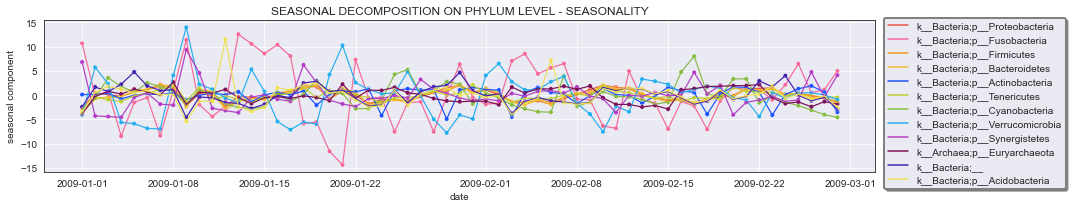

In [379]:
plt.figure(figsize =(15, 3))
ax = sns.lineplot(data=SEASONALITY_SHORT_DF,
                  x = 'index',
                  y = 'season', 
                  hue='feature',
                 linewidth = 1.2, 
                 palette = cmap)

ax = sns.scatterplot(data=SEASONALITY_SHORT_DF,
                     x = 'index',
                     y = 'season', 
                     hue='feature',
                     s = 20,
                     legend=False,
                     palette = cmap
                    )
leg = plt.legend(bbox_to_anchor=(1.005, 1.05), fancybox=True, shadow=True, edgecolor='grey')
leg.get_frame().set_linewidth(2.0)
ax.spines['top'].set_color('0.1')
ax.spines['bottom'].set_color('0.1')
ax.spines['right'].set_color('0.1')
ax.spines['left'].set_color('0.1')
plt.xlabel('date')
plt.ylabel('seasonal component')
plt.title('SEASONAL DECOMPOSITION ON PHYLUM LEVEL - SEASONALITY')
plt.tight_layout()
plt.savefig('ECCB_PLOTS/seasonal_decomposition_phylum.png')

In [312]:
idx = SEASONALITY_SHORT_DF[SEASONALITY_SHORT_DF['feature'] == 'k__Bacteria;p__Proteobacteria'].index

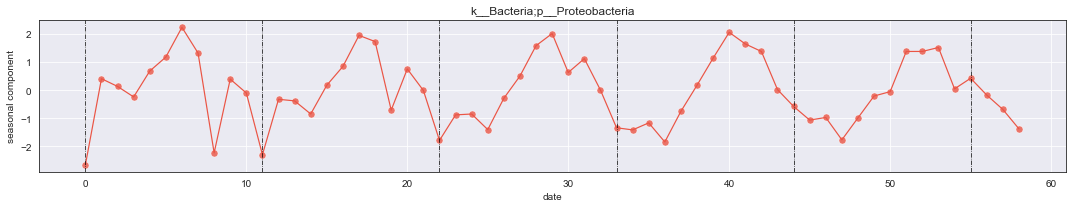

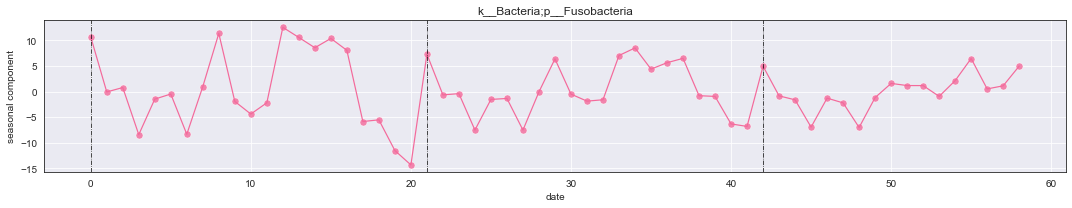

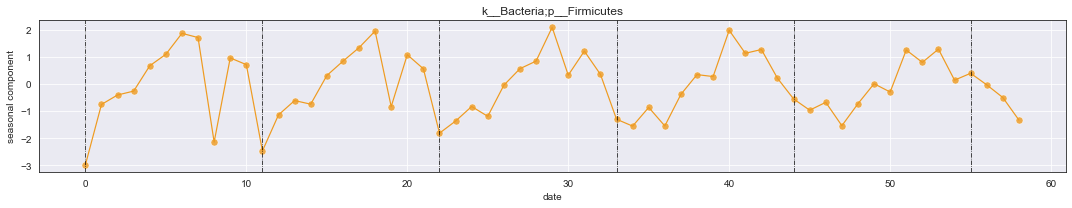

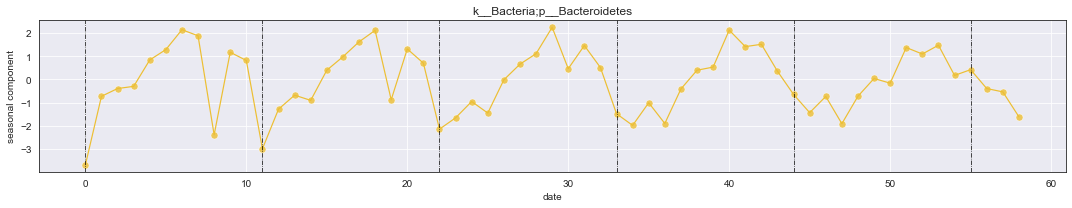

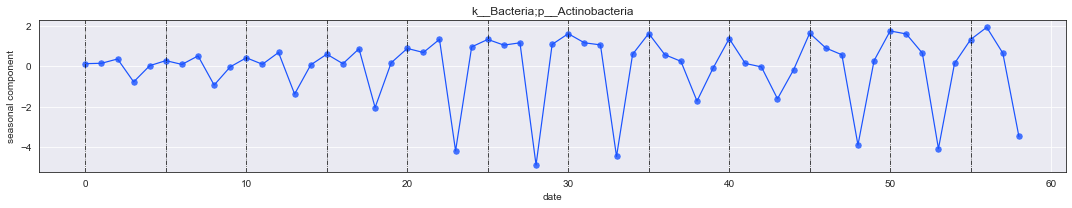

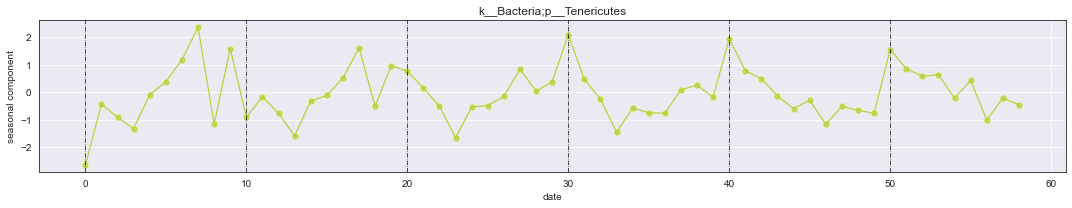

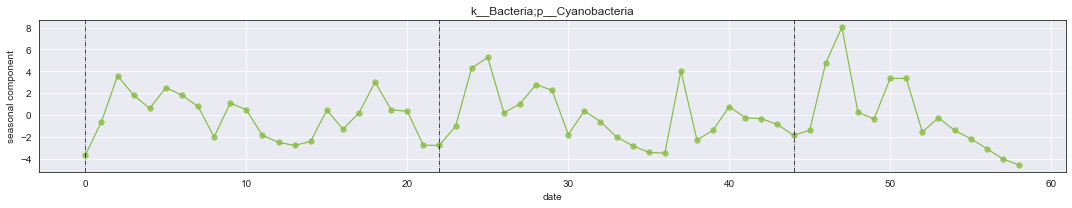

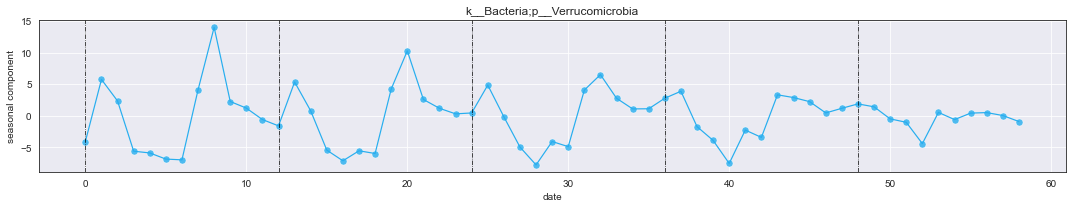

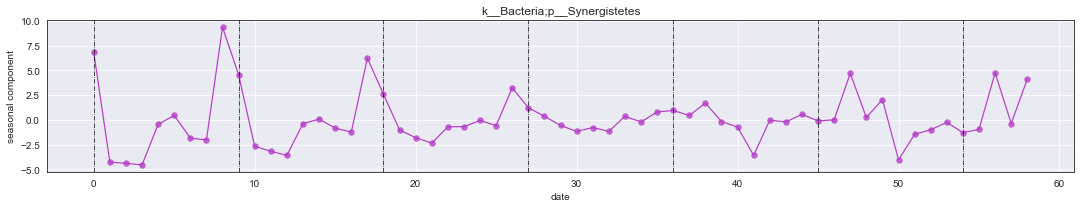

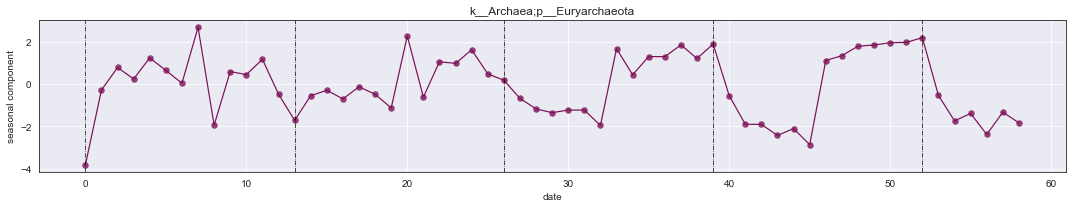

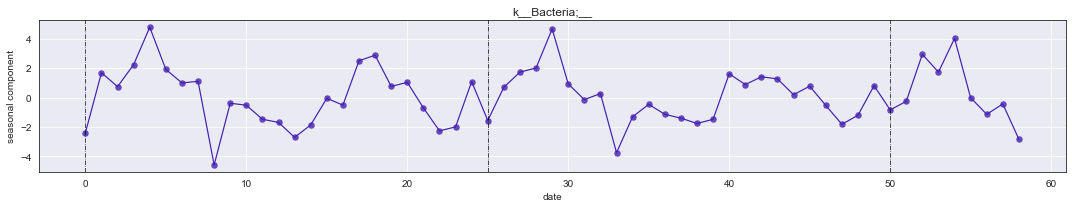

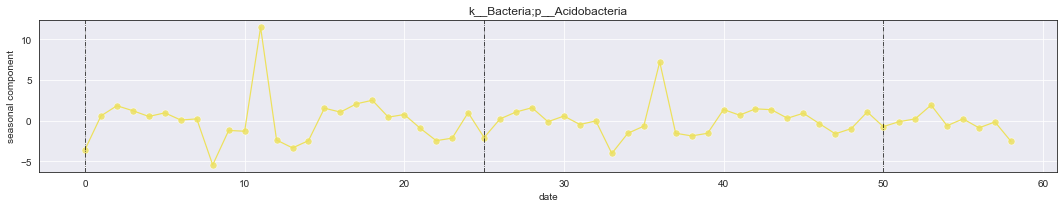

In [373]:
for feature in SEASONALITY_SHORT_DF['feature'].unique():
    

    plt.figure(figsize =(15, 3))
    plot_df = SEASONALITY_SHORT_DF[SEASONALITY_SHORT_DF['feature'] == feature]
    period = int(SEASONALITY_SHORT_DF[SEASONALITY_SHORT_DF['feature'] == feature]['period'].unique())

    ax = sns.lineplot(data = plot_df,
                      x = idx,
                      y = 'season',
                     color=cmap[feature],
                      linewidth = 1.2)

    ax = sns.scatterplot(data = plot_df,
                         x = idx,
                         y = 'season', 
                         color=cmap[feature],
                        alpha = .8,
                        s = 50)

    for i in range(0, (len(idx)//period)+1):
            plt.axvline(x=period*i, color='black', linestyle='-.', linewidth=.7)

    plt.title(feature)
    ax.spines['top'].set_color('0.1')
    ax.spines['bottom'].set_color('0.1')
    ax.spines['right'].set_color('0.1')
    ax.spines['left'].set_color('0.1')
    plt.xlabel('date')
    plt.ylabel('seasonal component')
    
    plt.tight_layout()
    plt.savefig('ECCB_PLOTS/seasonal_decomposition_{}.png'.format(feature))

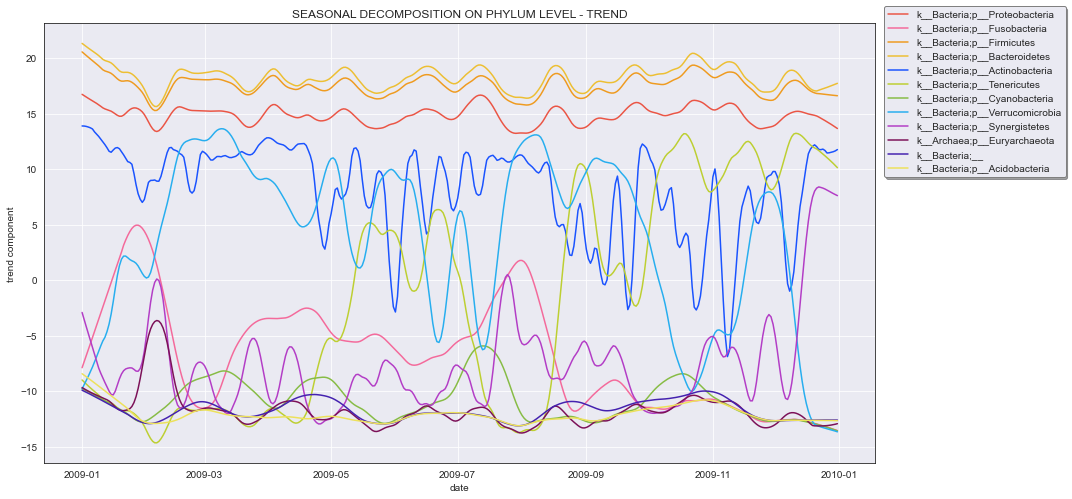

In [376]:
plt.figure(figsize =(15, 7))

ax = sns.lineplot(data = SEASONALITY_DF.reset_index(),
                  x = 'index',
                  y = 'trend',
                  hue = 'feature',
                  palette=cmap)

leg = plt.legend(bbox_to_anchor=(1.005, 1.05), fancybox=True, shadow=True, edgecolor='grey')
ax.spines['top'].set_color('0.1')
ax.spines['bottom'].set_color('0.1')
ax.spines['right'].set_color('0.1')
ax.spines['left'].set_color('0.1')
plt.xlabel('date')
plt.ylabel('trend component')
plt.title('SEASONAL DECOMPOSITION ON PHYLUM LEVEL - TREND')

plt.tight_layout()
plt.savefig('ECCB_PLOTS/seasonal_decomposition_phylum_trend.png')

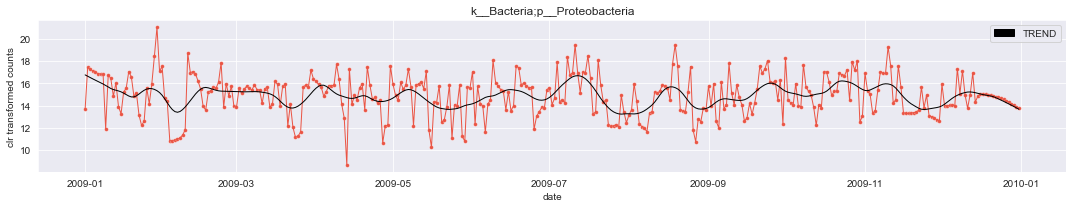

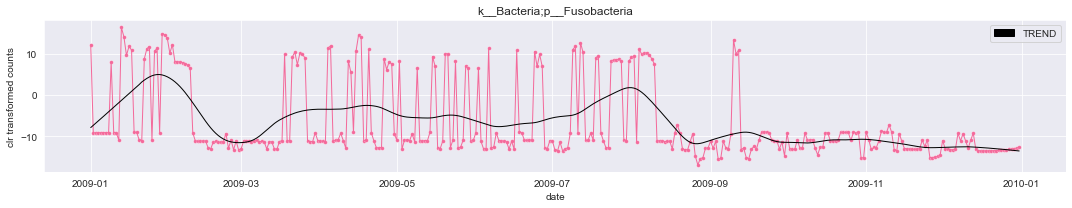

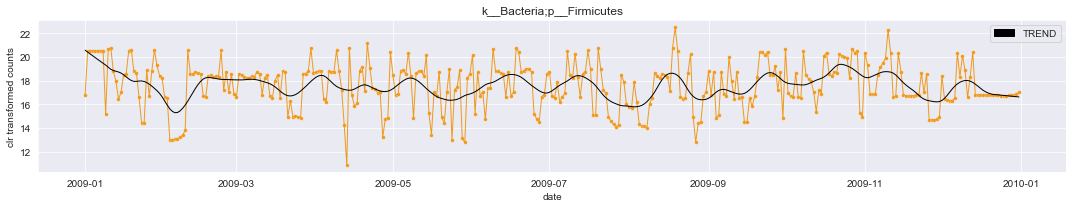

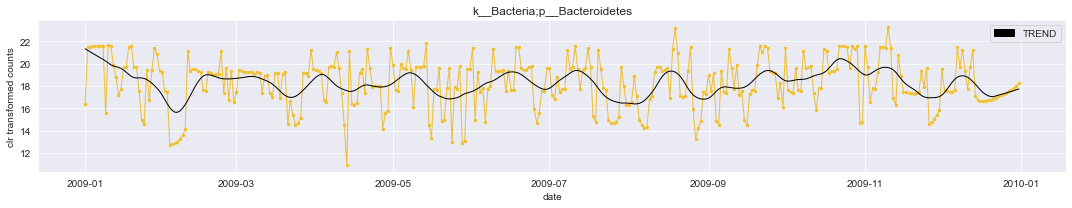

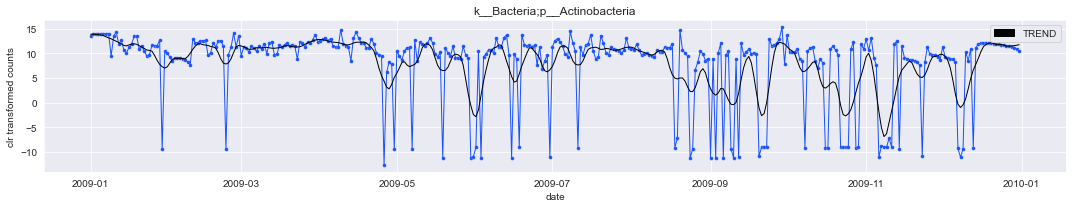

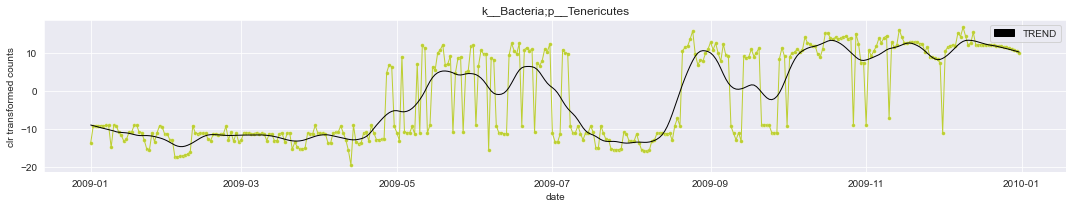

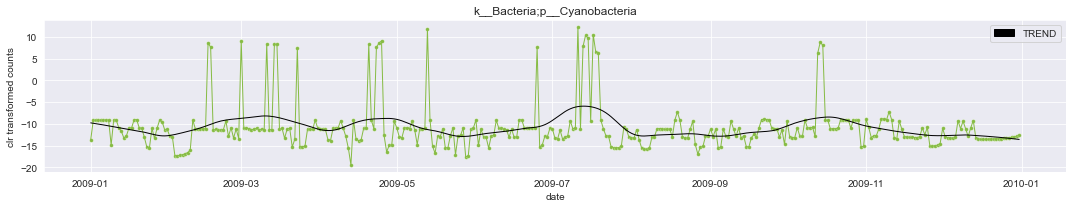

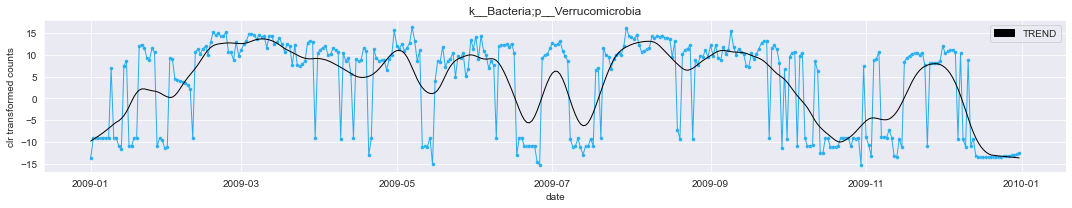

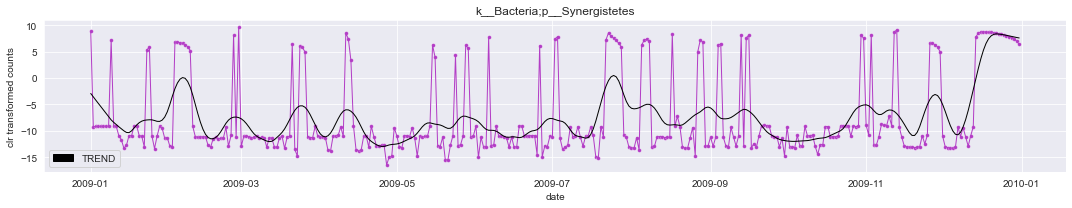

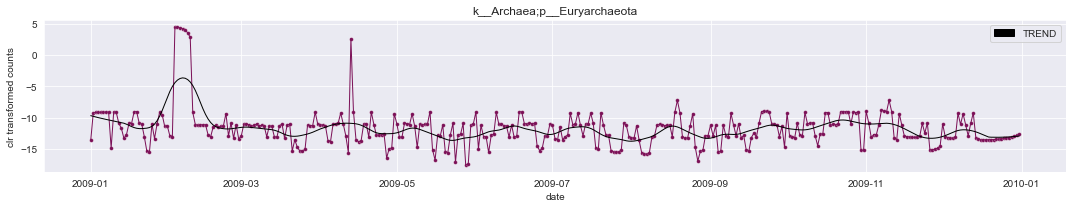

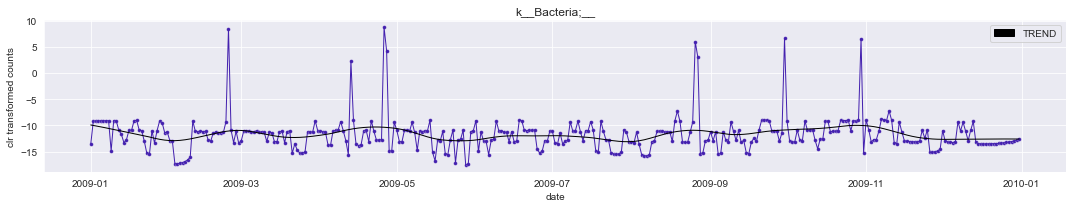

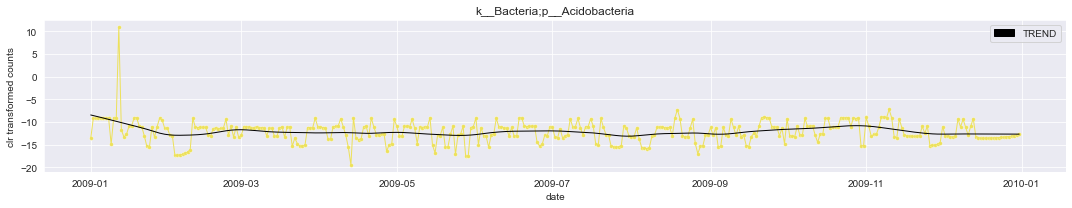

In [372]:
df = CLR_DF[CLR_DF.index.year == 2009]
for feature in SEASONALITY_SHORT_DF['feature'].unique():

    
    plt.figure(figsize =(15, 3))
    
    ax = sns.lineplot(data = df.reset_index(),
                      x = 'index',
                      y = df[feature].values,
                      color=cmap[feature],
                      linewidth = 1)
    
    ax = sns.scatterplot(data = df.reset_index(),
                         x = 'index',
                         y = df[feature].values,
                         color=cmap[feature], 
                         s = 15)
    
    ax = sns.lineplot(data = SEASONALITY_DF[SEASONALITY_DF['feature'] == feature].reset_index(),
                      x = 'index',
                      y = 'trend',
                      color='k',
                      linewidth=1)
    
    plt.title(feature)
    
    plt.xlabel('date')
    plt.ylabel('clr transformed counts')
    
    trend_patch = mpatches.Patch(color='k', label='TREND')
    plt.legend(handles=[trend_patch])

    plt.tight_layout()
    plt.savefig('ECCB_PLOTS/trend_decomposition_{}.png'.format(feature))
